# Topic Modelling - Notes and Playground
(July 06, 2019)

Instead of creating a formal Lit. Review, I would like to learn as much as needed to apply high level concepts for topic modelling. This will start by digging into blogs which utilize standard Python libraries and then push into more in-depth articles, papers, etc. regarding better implementation.

## Table of Contents

1. ["Applying Machine Learning to Classify an Unsupervised Text Documents"](#1)
    * Data -> TD-IDF -> K-means
    
2. ["pyLDAvis - Library for Interactive Topic Model Visualization"](#2)
    * Port of an R package
    
3. ["LDA in Python - How to Grid Search Best Topic Models"](#3)

4. ["Unsupervised LDA to Semi-Supervised GuidedLDA"](#4)

5. [""](#5)

6. ["Playground"](#6)

## Import Libraries and Data

In [1]:
# Imports

# Standard Libraries
from itertools import combinations

# Numerical Libraries
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Local Package Libraries
import sys
sys.path.append("../..")

from src.data.make_dataset import *
from src.features.general_helper_functions import *
from src.features.text_cleaning import *

In [2]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

In [3]:
# raw data import
_, watchlist_raw, stock_prices_raw = get_raw_data()
article_raw = clean_and_open_business_wire_data_01(None)

In [4]:
# Base data cleaning and formatting
articles = article_raw.copy()
articles.reset_index(inplace=True)
articles.time = pd.to_datetime(articles.time)

watchlist = watchlist_raw.copy()

<a id="1"></a>
## Applying Machine Learning to Classify an Unsupervised Text Documents

* Author builds a model to classify a data set into 2 classifications.
* Steps:
    1. Vectorize the text data by using sklearn's TfidfVectorizer
    2. Implements sklearn's KMeans cluster algorithm with true_k = 2
* The input document is a list of strings, by the appearance the strings are already relatively clean.

In [5]:
# Import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [6]:
titles_cleaned = clean_text(articles, "title").title.values

In [7]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(titles_cleaned)

print(X.shape)

(8433, 7676)


In [8]:
true_num_topics=3 # Obviously not true, but I will go with it for now

naive_kmeans_topic_model = KMeans(
    n_clusters=true_num_topics, 
    init="k-means++", 
    max_iter=100, 
    n_init=1)

naive_kmeans_topic_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Can now take a look at the top words in each centroid:

In [9]:
order_centroids = naive_kmeans_topic_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_num_topics):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("\n")

Cluster 0:
 result
 quarter
 announce
 financial
 conference
 report
 present
 pharmaceutical
 healthcare
 annual


Cluster 1:
 market
 researchandmarkets
 com
 global
 pipeline
 research
 review
 forecast
 analysis
 drug


Cluster 2:
 investor
 action
 class
 firm
 alert
 law
 deadline
 lawsuit
 llp
 contact




<a id="2"></a>
## pyLDAvis - Library for Interactive Topic Model Visualization
https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=1&lambda=0.5&term=

pyLDAvis is a library that ports an R script for topic visualization.

It is possible to oberlay it with gensim and sklearn.

**pyLDAvis**
https://pyldavis.readthedocs.io/en/latest/

**Gensim's LDA**
https://radimrehurek.com/gensim/models/ldamodel.html

In [10]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.tfidfmodel import TfidfModel
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [11]:
tokenized_titles_cleaned = [remove_short_words(text).split(" ") for text in titles_cleaned]
dictionary = corpora.Dictionary(tokenized_titles_cleaned)
dictionary.filter_extremes(no_below=5, no_above=0.4)

In [12]:
corpus = [dictionary.doc2bow(text) for text in tokenized_titles_cleaned]

In [13]:
tfidf_corpus = TfidfModel(corpus)[corpus]

In [14]:
lda = LdaModel(tfidf_corpus, num_topics=40)

In [15]:
for topic_id in range(4):
    print("Topic:", topic_id)
    print([(dictionary[item[0]], np.round(item[1],3)) for item in lda.get_topic_terms(topic_id)], "\n")

Topic: 0
[('dystrophy', 0.06), ('muscular', 0.056), ('worldwide', 0.034), ('duchenne', 0.03), ('case', 0.024), ('center', 0.024), ('anniversary', 0.021), ('list', 0.019), ('graft', 0.019), ('review', 0.019)] 

Topic: 1
[('epidemiology', 0.085), ('collaboration', 0.048), ('insight', 0.033), ('depression', 0.026), ('tablet', 0.025), ('allergic', 0.025), ('overview', 0.024), ('significant', 0.024), ('open', 0.023), ('researchandmarkets', 0.021)] 

Topic: 2
[('pacific', 0.061), ('insomnia', 0.058), ('asia', 0.057), ('east', 0.035), ('device', 0.032), ('surgery', 0.027), ('investment', 0.024), ('market', 0.021), ('outlook', 0.021), ('researchandmarkets', 0.02)] 

Topic: 3
[('anti', 0.067), ('biotechnology', 0.066), ('country', 0.044), ('antibody', 0.043), ('insight', 0.029), ('grant', 0.028), ('report', 0.028), ('process', 0.028), ('nasdaq', 0.027), ('rule', 0.026)] 



In [16]:
pyLDAvis.gensim.prepare(lda, tfidf_corpus, dictionary)

c:\users\michael\documents\projects and portfolio work\biopharmaceuticalfactormodel\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
25     0.192695 -0.011174       1        1  5.290287
6      0.193230 -0.017839       2        1  4.462393
37    -0.224498  0.282023       3        1  3.845564
8     -0.114113 -0.128650       4        1  3.464511
7     -0.180128 -0.202148       5        1  3.201598
31     0.147205 -0.015001       6        1  2.984921
26     0.102680 -0.011135       7        1  2.932913
18     0.120377 -0.010077       8        1  2.890163
17    -0.201394 -0.236732       9        1  2.759107
29    -0.057640 -0.066891      10        1  2.654118
27     0.146398 -0.005450      11        1  2.647577
36    -0.086313 -0.029424      12        1  2.642875
30    -0.184101 -0.196342      13        1  2.633994
22     0.089206 -0.025060      14        1  2.597974
10    -0.237608  0.140424      15        1  2.527273
13     0.084621  0.043411      16        1  2.507121
28    -0.098988  0.002784      17        1  2.436583
16    -0.076134  0.176892      18        1  2.363231
11     0.079148 -0.011496      19        1  2.342345
20    -0.067063  0.022099      20        1  2.329968
19     0.000754  0.002431      21        1  2.307499
1      0.111838 -0.021871      22        1  2.275561
0      0.100963  0.040786      23        1  2.264163
15    -0.054621  0.012152      24        1  2.263040
39    -0.143505  0.076547      25        1  2.218514
38     0.103716 -0.007372      26        1  2.207418
5     -0.041678 -0.023390      27        1  2.106785
32     0.045206 -0.018560      28        1  2.074980
3     -0.004393 -0.001536      29        1  2.033885
23     0.011876  0.131461      30        1  2.031775
12     0.097658 -0.024114      31        1  1.982120
33    -0.029459  0.104825      32        1  1.966602
24     0.090374  0.047460      33        1  1.940202
14    -0.086179  0.036685      34        1  1.922232
21    -0.065951  0.000655      35        1  1.915370
2      0.082265 -0.012495      36        1  1.891457
35     0.090070 -0.022709      37        1  1.843104
34     0.023274 -0.006286      38        1  1.829671
4     -0.065579  0.004575      39        1  1.774031
9      0.105790 -0.019457      40        1  1.637075, topic_info=     Category        Freq                Term       Total  loglift  logprob
46    Default  159.000000             quarter  159.000000  30.0000  30.0000
16    Default  177.000000              result  177.000000  29.0000  29.0000
44    Default  136.000000           financial  136.000000  28.0000  28.0000
156   Default  155.000000            investor  155.000000  27.0000  27.0000
2     Default  137.000000          conference  137.000000  26.0000  26.0000
51    Default  100.000000               board  100.000000  25.0000  25.0000
91    Default   85.000000                year   85.000000  24.0000  24.0000
855   Default   57.000000               image   57.000000  23.0000  23.0000
45    Default  103.000000               first  103.000000  22.0000  22.0000
89    Default   62.000000              fourth   62.000000  21.0000  21.0000
53    Default   92.000000            director   92.000000  20.0000  20.0000
50    Default   85.000000             appoint   85.000000  19.0000  19.0000
703   Default   50.000000       immunotherapy   50.000000  18.0000  18.0000
172   Default   78.000000                firm   78.000000  17.0000  17.0000
336   Default  101.000000             billion  101.000000  16.0000  16.0000
261   Default   58.000000            upcoming   58.000000  15.0000  15.0000
1270  Default   47.000000              needle   47.000000  14.0000  14.0000
108   Default   59.000000               offer   59.000000  13.0000  13.0000
7     Default  121.000000             present  121.000000  12.0000  12.0000
90    Default   54.000000                full   54.000000  11.0000  11.0000
470   Default   46.000000        epidemiology   46.000000  10.0000  10.0000
113   Default   51.000000               stock   51.000000  

<a id="3"></a>
## LDA Python - How to Grid Search Best Topic Models

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

<a id="4"></a>
## Unsupervised LDA to Semi-Supervised GuidedLDA

https://www.freecodecamp.org/news/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164/

## Topic Modelling Metrics

### Cluster Analysis
https://en.wikipedia.org/wiki/Cluster_analysis

#### Internal Evaluation
* Evaluation based on the data that was clustered itself
* Score high when there is high similarity within a cluster and low similarity between clusters
* Drawbacks:
    * High score on an internal measure do not necessarily result in effective information retrieval applications
    * Evaluation is biased toward algos that use the same cluster model

Note: LDA is technically not a clustering algorithm. It instead uses probability distributions. BUT as seen in the LDA visualization above, we can technically consider there to be clusters too. The definition of different clusters simply needs to be made discreet.

**SKlearn has various metrics for clustering algorithms.**

What we would be looking for are the unsupervised metrics such as:
* Silhouette Coefficient
    * best value is 1, worst is -1. 0 implies overlapping clusters
    * sklearn.metrics.silhouette_score(X(nsamples, nfeatures), labels)
* Calinski-Harabasz Index
    * Larger score is better
    * sklearn.metrics.calinski_harabasz_score(X(nsamples, nfeatures), labels)
* Davis-Bouldin Index
    * 0 is the lowest and best score. Closer to zero, the better
    * sklearn.metrics.davies_bouldin_score(X(nsamples, nfeatures), labels)

### Determining the Number of Clusters

https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

* Rate Distortion Theory

<a id="6"></a>
## Playground

In [17]:
from sklearn.metrics import *
import operator

### Finding the Best Number of Topics

To use SKLearn's silhouette_avg, need to predict the labels associated for each document. The classification vector goes in as the "label" input and the data goes in as the X.

In [18]:
def get_best_labels(model, corp):
    return [np.array([tuple_[1] for tuple_ in model.get_document_topics(doc)]).argmax() for doc in corp]

In [19]:
# Settings
max_N = 30
min_N = 3

# Initialize result holder
sill_results = {"best_model": None, "best_model_n": None, "best_score": -1.0}
cal_har_results = {"best_model": None, "best_model_n": None, "best_score": -np.inf}
dav_bou_results = {"best_model": None, "best_model_n": None, "best_score": np.inf}

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    sil_score = silhouette_score(X, best_labels)
    if sil_score > sill_results["best_score"]:
        sill_results["best_model"] = lda_n
        sill_results["best_model_n"] = model_n
        sill_results["best_score"] = sil_score
        
    cal_score = calinski_harabasz_score(X, best_labels)
    if cal_score > cal_har_results["best_score"]:
        cal_har_results["best_model"] = lda_n
        cal_har_results["best_model_n"] = model_n
        cal_har_results["best_score"] = cal_score
        
    dav_score = davies_bouldin_score(X, best_labels)
    if dav_score < dav_bou_results["best_score"]:
        dav_bou_results["best_model"] = lda_n
        dav_bou_results["best_model_n"] = model_n
        dav_bou_results["best_score"] = dav_score

KeyboardInterrupt: 

In [ ]:
print(sill_results)
print(cal_har_results)
print(dav_bou_results)

In [20]:
class NumTopicsScoreHolder:
    def __init__(self, metric_func, score_relation_direction=">"):
        self.metric_func = metric_func
        self.score_function = {">": operator.gt, "<": operator.lt}[score_relation_direction]
        
        self.score_df = pd.DataFrame(columns=["score", "model"])
        
    def update(self, X, model, n, labels):
        self.score_df = pd.concat([self.score_df, pd.DataFrame({"score": self.metric_func(X, labels), "model": model}, index=[n])])
        
    def get_best_model(self):
        indx = {operator.gt: 0, operator.lt: -1}[self.score_function]
        return self.score_df.sort_values("score", ascending=False).iloc[indx].model

In [21]:
# Settings
max_N = 50
min_N = 2

# Initialize result holder
sill_results = NumTopicsScoreHolder(silhouette_score, ">")
cal_har_results = NumTopicsScoreHolder(calinski_harabasz_score, ">")
dav_bou_results = NumTopicsScoreHolder(davies_bouldin_score, "<")

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    sill_results.update(X, lda_n, model_n, best_labels)
    cal_har_results.update(X, lda_n, model_n, best_labels)
    dav_bou_results.update(X, lda_n, model_n, best_labels)

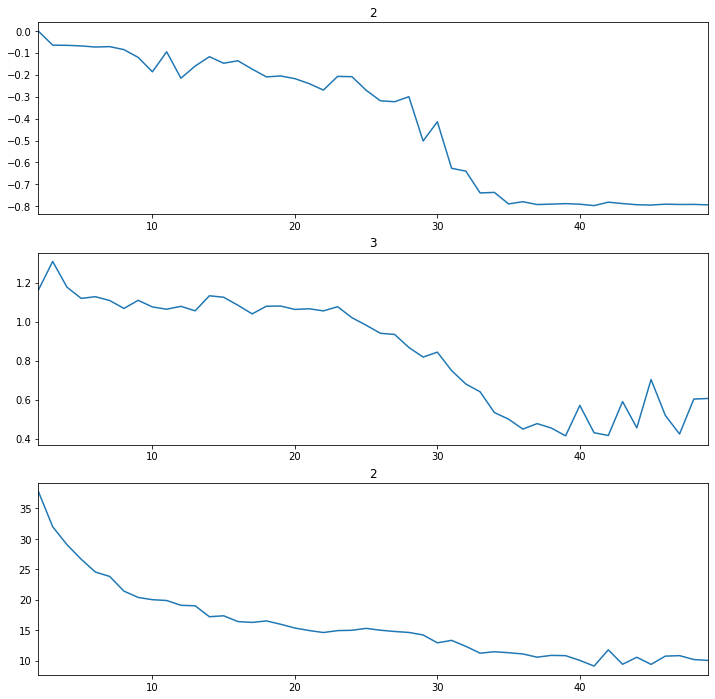

In [22]:
fig, ax = plt.subplots(3, figsize=(12, 12))

ax[0].set_title(sill_results.get_best_model().num_topics)
sill_results.score_df.score.plot(ax=ax[0])

ax[1].set_title(cal_har_results.get_best_model().num_topics)
cal_har_results.score_df.score.plot(ax=ax[1])

ax[2].set_title(dav_bou_results.get_best_model().num_topics)
dav_bou_results.score_df.score.plot(ax=ax[2])

From here, I would like to start taking a look at price statistics for each topic.

To do so I will need to:
1. Seperate the articles into their respective predicted labels
2. Using functionality from previous notebooks, get the window of prices after each event
3. Apply a set of statistics on the prices, and their returns over the window

In [23]:
# Clean price data and get the returns window
prices_df = clean_and_format_prices(stock_prices_raw, articles.ticker.unique())

# Return Window
return_window = compute_return_window(articles, prices_df, n_window=30)

return_window.sort_index().head()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,...,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29,R_30
0,0.016568,-0.017357,0.019329,0.012229,0.010651,0.008679,0.011045,-0.042998,0.002761,0.022880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.010794,-0.035081,-0.065921,-0.015420,-0.030840,-0.023130,0.000771,0.007710,-0.052043,-0.040093,...,-0.064765,-0.020046,-0.000386,0.026214,-0.008096,0.002313,NaN,NaN,NaN,NaN
3,0.013173,0.006587,0.001162,-0.045719,-0.008136,0.005037,-0.005812,-0.030221,-0.061217,-0.010461,...,-0.034870,0.001162,-0.005812,-0.007361,-0.009299,-0.006974,-0.060054,-0.015110,0.004649,0.031383
4,0.040000,0.050588,0.012157,0.025490,0.018824,0.013333,-0.034118,0.003922,0.017255,0.006275,...,-0.043529,-0.005882,0.010588,-0.023137,0.013333,0.006275,0.004706,0.002745,0.005098,-0.048627


In [51]:
def sharpe_ratio(mean, dev, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * mean - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * dev)
    return num / den


def downside_deviation(series):
    mean = series.mean()
    shifted_series = series - mean
    neg_values = shifted_series.loc[shifted_series < 0]
    neg_var = (neg_values ** 2).sum() / neg_values.shape[0]
    return np.sqrt(neg_var)


def sortino_ratio(series, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * series.mean() - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * downside_deviation(series))
    return num / den
    

def report_statistics(series):
    risk_free_rate  = 0.025
    num_days = 30
    
    mean = np.mean(series)
    dev = np.std(series)
    downside_dev = downside_deviation(series)
    skew_ = skew(series)
    kurt_ = kurtosis(series)
    
    sharpe_ratio_ = sharpe_ratio(mean, dev, num_days, risk_free_rate)
    sortino_ratio_ = sortino_ratio(series, num_days, risk_free_rate)
    
    print_statement = """
    STATISTICAL REPORT:
        If held for {} days, the returns for the topic had the following statistics:
        * mean = {}
        * standard deviation = {}
        * downside deviation = {}
        * skew = {}
        * kurtosis = {}
        
        Sharpe Ratio = {}
        Sortino Ratio = {}
    """. format(np.round(num_days, 4), np.round(mean, 4), np.round(dev, 4), np.round(downside_dev, 4), np.round(skew_, 4),
                np.round(kurt_, 4), np.round(sharpe_ratio_, 4), np.round(sortino_ratio_, 4))
    
    return print_statement

**Best Model Using the Sillhouette Coefficient**

In [52]:
sill_article_df = articles.copy()

sill_article_df["labels"] = get_best_labels(sill_results.get_best_model(), tfidf_corpus)

for topic in range(sill_results.get_best_model().num_topics):
    
    articles_in_topic = sill_article_df.loc[sill_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0211
        * standard deviation = 0.2124
        * downside deviation = 0.168
        * skew = 1.8569
        * kurtosis = 11.3958
        
        Sharpe Ratio = 0.2475
        Sortino Ratio = 0.3128
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0192
        * standard deviation = 0.2196
        * downside deviation = 0.1774
        * skew = 1.6159
        * kurtosis = 8.1162
        
        Sharpe Ratio = 0.2145
        Sortino Ratio = 0.2655
    





In [54]:
ch_article_df = articles.copy()

ch_article_df["labels"] = get_best_labels(cal_har_results.get_best_model(), tfidf_corpus)

for topic in range(cal_har_results.get_best_model().num_topics):
    
    articles_in_topic = ch_article_df.loc[ch_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.017
        * standard deviation = 0.1993
        * downside deviation = 0.1615
        * skew = 1.3441
        * kurtosis = 5.7793
        
        Sharpe Ratio = 0.2032
        Sortino Ratio = 0.2508
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0249
        * standard deviation = 0.2259
        * downside deviation = 0.1779
        * skew = 2.0422
        * kurtosis = 12.4494
        
        Sharpe Ratio = 0.2818
        Sortino Ratio = 0.3579
    



Topic 2 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0196
        * standard deviation = 0.2215
        * downside deviat

In [53]:
db_article_df = articles.copy()

db_article_df["labels"] = get_best_labels(dav_bou_results.get_best_model(), tfidf_corpus)

for topic in range(dav_bou_results.get_best_model().num_topics):
    
    articles_in_topic = db_article_df.loc[db_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0211
        * standard deviation = 0.2123
        * downside deviation = 0.168
        * skew = 1.8573
        * kurtosis = 11.401
        
        Sharpe Ratio = 0.2473
        Sortino Ratio = 0.3125
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0193
        * standard deviation = 0.2197
        * downside deviation = 0.1775
        * skew = 1.6153
        * kurtosis = 8.1103
        
        Sharpe Ratio = 0.2148
        Sortino Ratio = 0.2659
    





Now, for the next steps, I think what might be interested is using the sharpe ratio and sortino ratio as the metric for determining the number of topics.

Could take a look at that tomorrow.